In [1]:
import subprocess
subprocess.check_output(["maturin", "develop"])
import time

🍹 Building a mixed python/rust project
🔗 Found pyo3 bindings
🐍 Found CPython 3.10 at /home/wint3rmute/code/luthier/.venv/bin/python
📡 Using build options features from pyproject.toml
   Compiling pyo3-build-config v0.18.3
   Compiling pyo3-ffi v0.18.3
   Compiling pyo3 v0.18.3
   Compiling numpy v0.18.0
   Compiling luthier v0.1.0 (/home/wint3rmute/code/luthier)
    Finished dev [unoptimized + debuginfo] target(s) in 3.83s
📦 Built wheel for CPython 3.10 to /tmp/.tmpwgd6Ho/luthier-0.1.0-cp310-cp310-linux_x86_64.whl
🛠 Installed luthier-0.1.0


In [2]:
import numpy as np
import audioflux as af
from audioflux.type import SpectralFilterBankScaleType
from IPython.display import Audio, display, Image, HTML
import matplotlib.pyplot as plt
from audioflux.display import fill_spec
import random
import PIL
from tqdm.notebook import tqdm
from copy import deepcopy
from IPython.display import clear_output
import librosa
from scipy.optimize import differential_evolution
import soundfile as sf
from multiprocessing import Pool
import os
from luthier.luthier import DspGraph, SineOscillator, Multiplier, HarmonicMultiplier, Sum, ADSR
from luthier.dsp import Sample
plt.rcParams['figure.dpi'] = 110
SAMPLE_RATE = 22050

Target sample rate 22050
Generator sample rate 22050


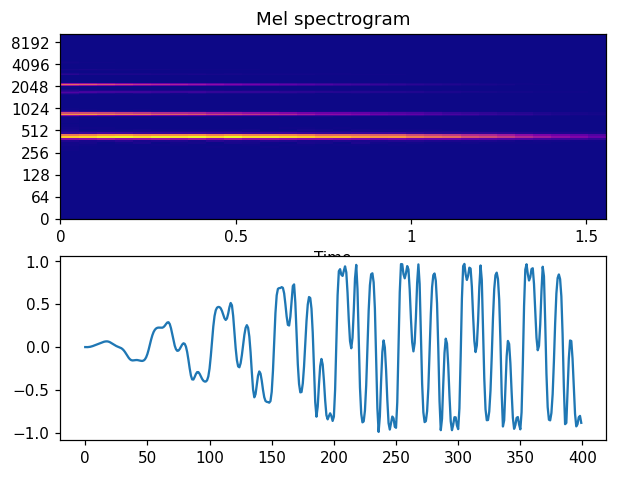

In [3]:
fm_sample_data, fm_sample_sample_rate = librosa.load('./fm_sample.wav')
print("Target sample rate", fm_sample_sample_rate)
print("Generator sample rate", SAMPLE_RATE)

fm_sample = Sample(fm_sample_data[100:])

fig, (ax, ax2) = plt.subplots(2, 1, sharex=False, sharey=False)
fm_sample.plot_spectrogram(ax)
ax2.plot(fm_sample.buffer[:400])

fm_sample.show_player()

In [ ]:
STEP_VALUE = 20 # Lower means better resolution
mod_freqs = [ a / 100 for a in range(-100, 101, STEP_VALUE) ] 
mod_strengths = [ a / 100 for a in range(-100, 101, STEP_VALUE) ] 

test_cases = []
for freq_index, freq in enumerate(mod_freqs):
    for mod_index, mod_strength in enumerate(mod_strengths):    
        test_cases.append( ( (freq_index, freq), (mod_index, mod_strength) ) )

def get_distance_variable_mod_strength(test_case):
    (freq_index, freq), (mod_index, mod_strength) = test_case
    graph = one_operator_fm()

    graph.set_input(6, "input_scale", freq)
    graph.set_input(5, "input_scale", mod_strength)
    generated_audio = Sample(graph.play(SAMPLE_RATE * 1))

    dist = target_audio.mfcc_distance(generated_audio)
    
    return freq_index, mod_index, dist
    
with Pool() as p:
    pool_results = list(tqdm(p.imap(get_distance_variable_mod_strength, test_cases), total=len(test_cases)))  
    
results = np.zeros((len(mod_freqs), len(mod_strengths)))

for pool_result in pool_results:
    freq_index, mod_index, dist = pool_result
    results[freq_index][mod_index] = dist
    
fig, ax = plt.subplots()
im = ax.imshow(results)

# Show all ticks and label them with the respective list entries
ax.set_xticks(np.arange(len(mod_strengths)), labels=mod_strengths)

plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")
ax.set_yticks(np.arange(len(mod_freqs)), labels=mod_freqs)
ax.set_ylabel("Modulation frequency")
ax.set_xlabel("Modulation strength")
fig.tight_layout()

In [ ]:
def multiplier_with_param(graph: DspGraph):
    mult = graph.add_multiplier(Multiplier())
    return mult

def adsr_with_params(graph: DspGraph):
    adsr = graph.add_adsr(ADSR())
    return adsr

def oscillator_with_multiplier(graph: DspGraph):
    osc = graph.add_sine(SineOscillator())
    mod_osc = graph.add_sine(SineOscillator())
    
    mod_osc_freq_mult = graph.add_harmonic_multiplier(HarmonicMultiplier())
    graph.set_input(mod_osc_freq_mult, "input_scale", random.uniform(-1.0, 1.0))
    
    graph.patch(graph.base_frequency_node_id, "output_output", mod_osc_freq_mult, "input_input")
    graph.patch(graph.base_frequency_node_id, "output_output", osc, "input_frequency")
    graph.patch(mod_osc_freq_mult, "output_output", mod_osc, "input_frequency")
    
    mod_adsr = adsr_with_params(graph)
    osc_adsr = adsr_with_params(graph)
    
    graph.patch(mod_osc, "output_output", mod_adsr, "input_input")
    graph.patch(osc, "output_output", osc_adsr, "input_input")
    
    graph.patch(mod_adsr, "output_output", osc, "input_modulation")
    mult = multiplier_with_param(graph)
    graph.patch(osc, "output_output", mult, "input_input")
    return mult


def oscillator_with_adsr(graph: DspGraph):
    mult = oscillator_with_multiplier(graph)
    adsr = adsr_with_params(graph)  
    graph.patch(mult, "output_output", adsr, "input_input")
    
    return adsr
    
def complex_fm():
    graph = DspGraph()
    mixer = graph.add_sum(Sum())
    graph.patch(mixer, "output_output", graph.amp_adsr_node_id, "input_input")

    osc_output_node = oscillator_with_adsr(graph)
    graph.patch(osc_output_node, "output_output", mixer, "input_in_1")

#     osc_output_node = oscillator_with_adsr(graph)
#     graph.patch(osc_output_node, "output_output", mixer, "input_in_2")

#     osc_output_node = oscillator_with_adsr(graph)
#     graph.patch(osc_output_node, "output_output", mixer, "input_in_3")
    
    return graph

graph = complex_fm()
    
# osc_output_node = oscillator_with_adsr(graph)
# graph.patch(osc_output_node, "output", mixer, "in_4")

# from copy import deepcopy
# best_graph = deepcopy(graph)

generated_audio = Sample(graph.play(SAMPLE_RATE * 2))
# generated_audio = graph.save_video(SAMPLE_RATE * 2)

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=False, sharey=False)
generated_audio.plot_spectrogram(ax1)
generated_audio.plot_waveform(ax2, num_samples=400)
generated_audio.plot_mfcc(ax3)
generated_audio.show_player()
plt.show()

display(Image(graph.draw()))
distances = []